### Plot a few samples, Initialize data loaders

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
import sys

from PIL import Image, ImageFile
from tqdm import tqdm

from dataset import YOLODataset
import config

from utils import (
    cells_to_bboxes,
    iou_width_height as iou,
    non_max_suppression as nms,
    plot_image,
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)

from model import YOLOv3

from loss import YoloLoss

torch.backends.cudnn.benchmark = True

ImageFile.LOAD_TRUNCATED_IMAGES = True

notebook_dir = os.getcwd()

# root_dir = os.path.abspath(os.path.join(notebook_dir, '../..'))

sys.path.append(notebook_dir)

check pytorch installation


In [2]:
print(torch.rand(5, 3))
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print (torch.cuda.current_device())
print (torch.version.cuda)

tensor([[0.4623, 0.5997, 0.5341],
        [0.2686, 0.5605, 0.9845],
        [0.5410, 0.6024, 0.0048],
        [0.7654, 0.9247, 0.3053],
        [0.8331, 0.0871, 0.1909]])
True
NVIDIA GeForce RTX 3070 Laptop GPU
0
12.6


In [3]:
from utils import seed_everything

seed_everything(seed = 2517)

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.0377369299530983, 0.5250576138496399, 0.0754738599061966, 0.08574090152978897], [0.0, 1.0, 0.09371732175350189, 0.5192618370056152, 0.11570261418819427, 0.0653739795088768], [0.0, 1.0, 0.17391341924667358, 0.5143502354621887, 0.08501634746789932, 0.043697237968444824], [0.0, 1.0, 0.2861029803752899, 0.4880729019641876, 0.10616014897823334, 0.09445090591907501], [0.0, 1.0, 0.5175163149833679, 0.5257861018180847, 0.1016993597149849, 0.09630094468593597], [0.0, 1.0, 0.68895423412323, 0.5108219981193542, 0.16748370230197906, 0.07121880352497101], [0.0, 1.0, 0.7661764621734619, 0.510224461555481, 0.24620915949344635, 0.12929080426692963], [0.0, 1.0, 0.8985294699668884, 0.5477248430252075, 0.2029411941766739, 0.17717933654785156], [0.0, 1.0, 0.9454085826873779, 0.6049290895462036, 0.10918296128511429, 0.254914253950119], [0.0, 1.0, 0

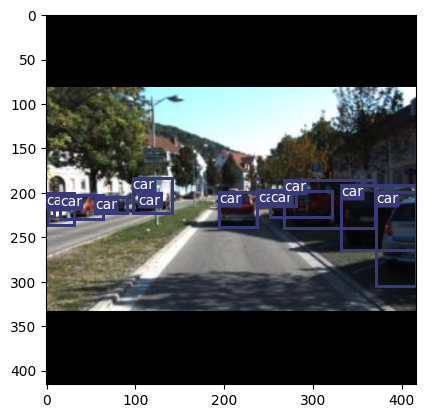

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.06909313797950745, 0.4994433522224426, 0.1381862759590149, 0.13064971566200256], [0.0, 1.0, 0.22491832077503204, 0.5282501578330994, 0.194019615650177, 0.16570241749286652], [0.0, 1.0, 0.5234314203262329, 0.49368855357170105, 0.048006534576416016, 0.05224348604679108], [0.0, 1.0, 0.6824183464050293, 0.5229946970939636, 0.09650325775146484, 0.08151691406965256], [0.0, 1.0, 0.8578432202339172, 0.4767106771469116, 0.20692814886569977, 0.07935578376054764], [0.0, 1.0, 0.1295424848794937, 0.5919705033302307, 0.2590849995613098, 0.18253302574157715], [0.0, 1.0, 0.7309396266937256, 0.5514658093452454, 0.19214047491550446, 0.12362603843212128], [0.0, 1.0, 0.8397876620292664, 0.5840791463851929, 0.26369285583496094, 0.18086303770542145], [0.0, 1.0, 0.5234314203262329, 0.49368855357170105, 0.048006534576416016, 0.05224348604679108], [0.0

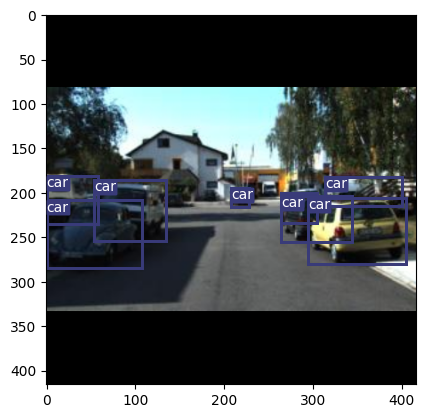

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.3774999976158142, 0.5359532237052917, 0.044509828090667725, 0.040701162070035934], [0.0, 1.0, 0.462908536195755, 0.5286922454833984, 0.0560457743704319, 0.0547320619225502], [0.0, 1.0, 0.3774999976158142, 0.5359532237052917, 0.044509828090667725, 0.040701162070035934], [0.0, 1.0, 0.462908536195755, 0.5286922454833984, 0.0560457743704319, 0.0547320619225502], [0.0, 1.0, 0.3774999976158142, 0.5359532237052917, 0.044509828090667725, 0.040701162070035934], [0.0, 1.0, 0.462908536195755, 0.5286922454833984, 0.0560457743704319, 0.0547320619225502]]


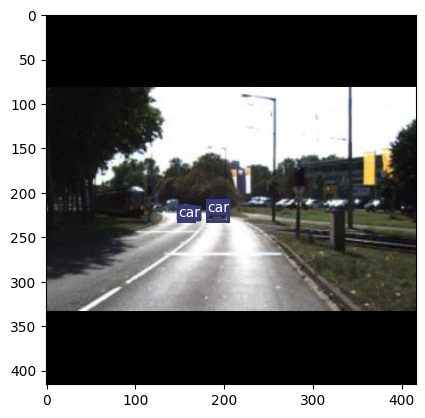

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.24036766588687897, 0.5685829520225525, 0.19207514822483063, 0.12609824538230896], [0.0, 1.0, 0.24036766588687897, 0.5685829520225525, 0.19207514822483063, 0.12609824538230896], [0.0, 1.0, 0.24036766588687897, 0.5685829520225525, 0.19207514822483063, 0.12609824538230896]]


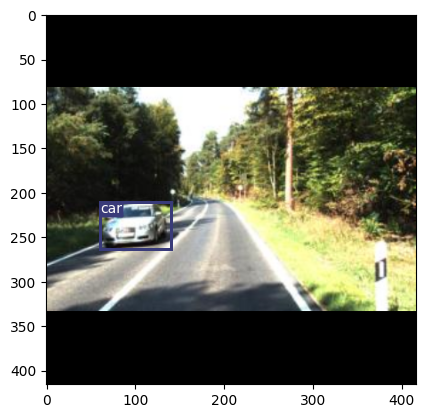

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.9959477186203003, 0.48098379373550415, 0.008104562759399414, 0.04143789783120155], [0.0, 1.0, 0.03302287682890892, 0.5613628029823303, 0.06604575365781784, 0.11722452938556671], [0.0, 1.0, 0.07820262014865875, 0.546292245388031, 0.1564052402973175, 0.08610109239816666], [0.0, 1.0, 0.9959477186203003, 0.48098379373550415, 0.008104562759399414, 0.04143789783120155], [0.0, 1.0, 0.03302287682890892, 0.5613628029823303, 0.06604575365781784, 0.11722452938556671], [0.0, 1.0, 0.07820262014865875, 0.546292245388031, 0.1564052402973175, 0.08610109239816666], [0.0, 1.0, 0.9959477186203003, 0.48098379373550415, 0.008104562759399414, 0.04143789783120155], [0.0, 1.0, 0.07820262014865875, 0.546292245388031, 0.1564052402973175, 0.08610109239816666], [0.0, 1.0, 0.03302287682890892, 0.5613628625869751, 0.06604575365781784, 0.11722452938556671]]


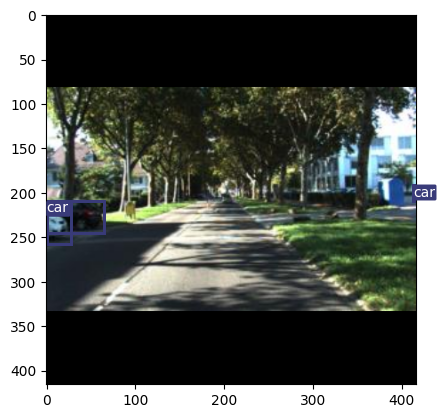

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.3818545937538147, 0.5091357231140137, 0.05854577198624611, 0.03660811111330986], [0.0, 1.0, 0.4389706254005432, 0.5083743929862976, 0.060392145067453384, 0.040357332676649094], [0.0, 1.0, 0.536617636680603, 0.5288068056106567, 0.09114382416009903, 0.08567539602518082], [0.0, 1.0, 0.3818545937538147, 0.5091357231140137, 0.05854577198624611, 0.03660811111330986], [0.0, 1.0, 0.4389706254005432, 0.5083743929862976, 0.060392145067453384, 0.040357332676649094], [0.0, 1.0, 0.536617636680603, 0.5288068056106567, 0.09114382416009903, 0.08567539602518082], [0.0, 1.0, 0.3818545937538147, 0.5091357231140137, 0.05854577198624611, 0.03660811111330986], [0.0, 1.0, 0.4389706254005432, 0.5083743929862976, 0.060392145067453384, 0.040357332676649094], [0.0, 1.0, 0.536617636680603, 0.5288068056106567, 0.09114382416009903, 0.08567539602518082]]


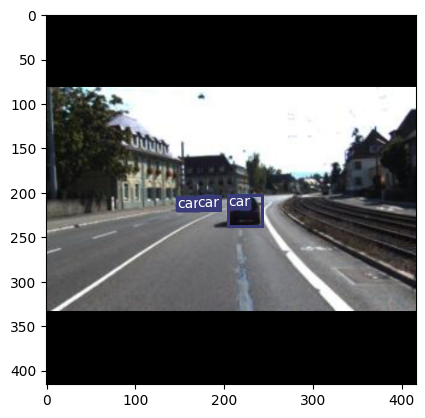

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.11390522867441177, 0.5280864238739014, 0.0775490328669548, 0.0425511933863163], [0.0, 1.0, 0.1830228716135025, 0.5151606202125549, 0.05630720034241676, 0.03664084151387215], [0.0, 1.0, 0.11390522867441177, 0.5280864238739014, 0.0775490328669548, 0.0425511933863163], [0.0, 1.0, 0.1830228716135025, 0.5151606202125549, 0.05630720034241676, 0.03664084151387215], [0.0, 1.0, 0.1830228716135025, 0.5151606202125549, 0.05630720034241676, 0.03664084151387215], [0.0, 1.0, 0.11390522867441177, 0.5280864238739014, 0.0775490328669548, 0.0425511933863163]]


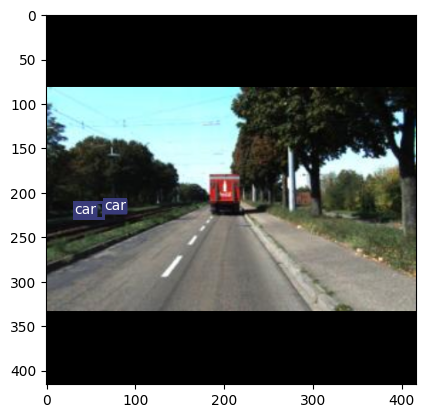

In [4]:
anchors = config.ANCHORS

transform = config.test_transforms

dataset = YOLODataset(
    r"KITTI_YOLO/train.csv",
    r"KITTI_YOLO/images",
    r"KITTI_YOLO/labels",
    S=[13, 26, 52],
    anchors=anchors,
    transform=transform,
)
S = [13, 26, 52]
scaled_anchors = torch.tensor(anchors) / (
    1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
)
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

for index, (x, y) in enumerate (loader):
    boxes = []

    for i in range(y[0].shape[1]):
        anchor = scaled_anchors[i]
        print(anchor.shape)
        print(y[i].shape)
        boxes += cells_to_bboxes(
            y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
        )[0]
    boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
    print(boxes)
    plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes, class_labels_list = config.KITTI_CLASSES)
    
    if index > 5 :
        break